In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
X_df= pd.read_json('mydata-mitbih-small.json')

In [8]:
X_data = np.array(X_df.sample(frac=1))
Y_data = X_data[:,-1]
X_data = X_data[:,:-1]

Y_data = 1.*(Y_data > 0.)

In [9]:
ind = 0

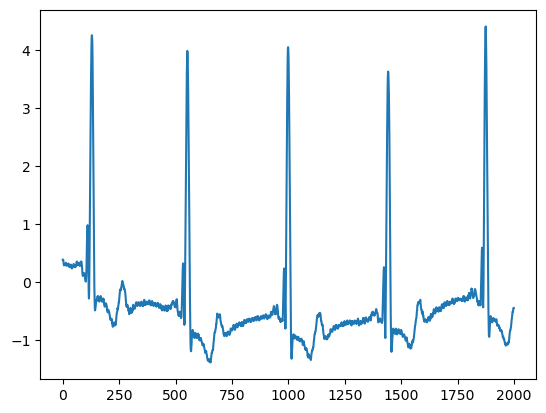

In [10]:
plt.plot(X_data[ind])

c:\Users\aejog\anaconda3\Lib\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


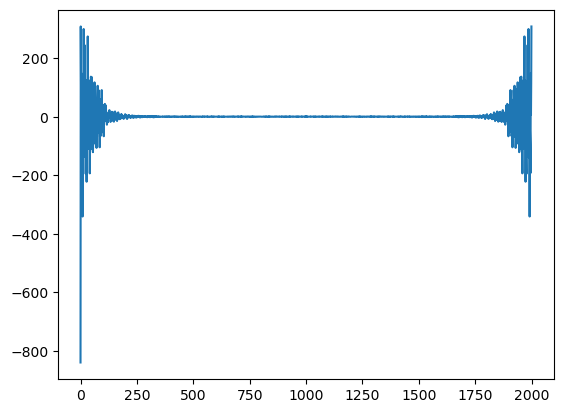

In [11]:
fX = np.fft.fft(X_data,axis = 1)
plt.plot(fX[ind])

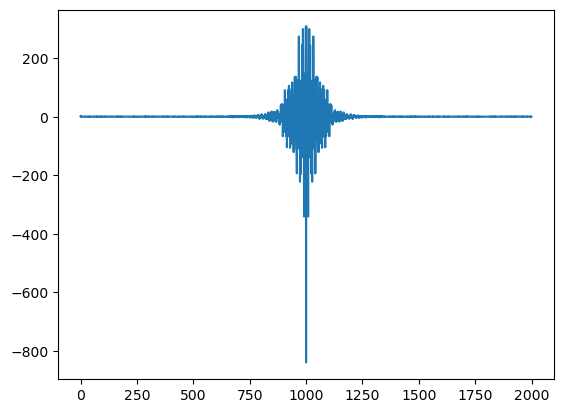

In [12]:
fX_ = np.fft.ifftshift(fX,axes = 1)
plt.plot(fX_[ind])

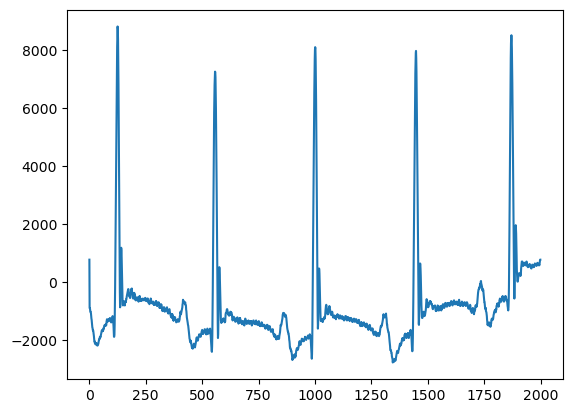

In [13]:
ffX = np.fft.fft(fX,axis = 1)
plt.plot(ffX[ind])

In [14]:
ks = np.fft.fftfreq(X_data.shape[-1])

tau = np.arange(X_data.shape[-1])[None,:] / X_data.shape[-1]
cosk = np.cos(np.pi * 2*ks[:,None] * tau)
# cosk = np.fft.ifftshift(cosk)

(fX_[ind][:,None]*cosk).mean(axis=-1)

array([1.3749295 +2.88657986e-15j, 0.33226585-5.32489178e-01j,
       0.85248221-5.03610114e-01j, ..., 0.36040102+3.51360897e-01j,
       0.85248221+5.03610114e-01j, 0.33226585+5.32489178e-01j])

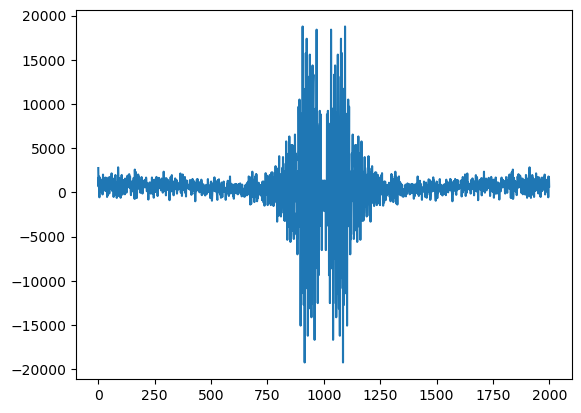

In [15]:
plt.plot((fX_[ind][:,None]*cosk).sum(axis=-1))

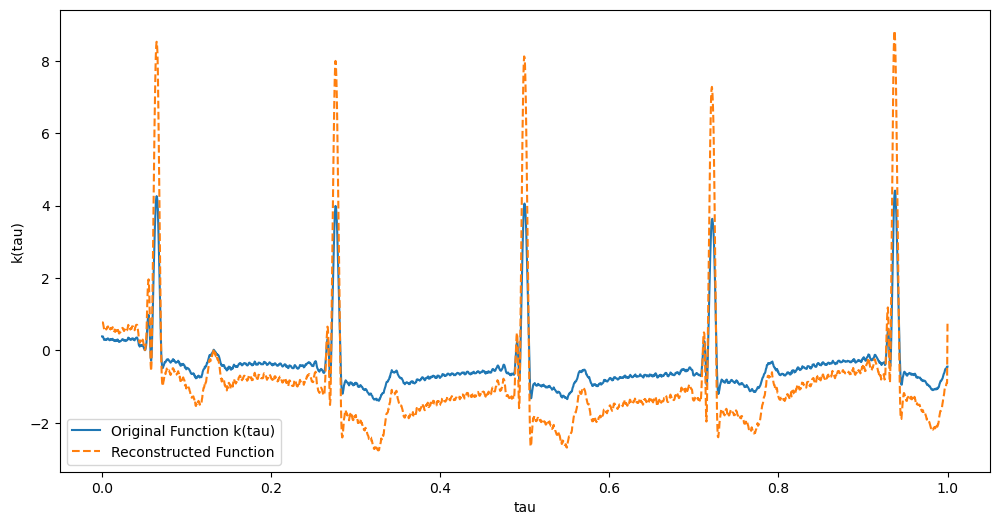

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftfreq

# Define the target function k(tau)
def k(tau):
    return np.exp(-tau**2) * np.cos(2 * np.pi * 5 * tau)

# Number of sample points
N = 2000
# Sample spacing
T = 1.0 / N
# Generate the tau values
tau = np.linspace(0.0, N*T, N)

# Compute the target function values
k_values = k(tau)
k_values = X_data[0]
# Compute the Fourier coefficients S(w) using FFT
S_w = fft(k_values)

# Frequencies corresponding to the coefficients
frequencies = fftfreq(N, T)

# Reconstruct the function using the sum of cosines
reconstructed_k = np.zeros(N)
for i in range(N):
    w = frequencies[i]
    amplitude = 2.0/N * np.abs(S_w[i])
    phase = np.angle(S_w[i])
    reconstructed_k += amplitude * np.cos(2 * np.pi * w * tau + phase)

# Plot the original and reconstructed functions
plt.figure(figsize=(12, 6))
plt.plot(tau, k_values, label='Original Function k(tau)')
plt.plot(tau, reconstructed_k, label='Reconstructed Function', linestyle='--')
plt.xlabel('tau')
plt.ylabel('k(tau)')
plt.legend()
plt.show()


In [18]:
import numpy as np
from scipy.optimize import minimize
from scipy.linalg import cholesky, cho_solve

# Define the kernel function
def kernel(tau, theta):
    Q = len(theta) // 3
    a = theta[:Q]
    mu = theta[Q:2*Q]
    sigma = theta[2*Q:]
    K = np.zeros((len(tau), len(tau)))
    for i in range(Q):
        K += a[i] * np.exp(-2 * np.pi**2 * sigma[i]**2 * np.subtract.outer(tau, tau)**2) * np.cos(2 * np.pi * mu[i] * np.subtract.outer(tau, tau))
    return K

# Define the log marginal likelihood
def log_marginal_likelihood(theta, tau, y, noise_variance):
    try:
        K = kernel(tau, theta) + noise_variance * np.eye(len(tau))
        L = cholesky(K, lower=True)
        alpha = cho_solve((L, True), y)
        log_likelihood = -0.5 * np.dot(y, alpha) - np.sum(np.log(np.diag(L))) - 0.5 * len(tau) * np.log(2 * np.pi)
        return -log_likelihood
    except np.linalg.LinAlgError as e:
        print("LinAlgError:", e)
        return np.inf

# Generate synthetic data
np.random.seed(0)
N = 50
tau = np.linspace(0, 1, N)
true_theta = [1.0, 0.5, 0.1, 0.8, 1.0, 0.2, 0.5, 1.5, 0.3]
noise_variance = 0.1
y = np.sin(2 * np.pi * tau) + np.random.normal(0, np.sqrt(noise_variance), N)

# Initial guess for the hyperparameters
initial_theta = np.random.rand(9)

# Define bounds for the hyperparameters to avoid invalid values
bounds = [(1e-5, None)] * 3 + [(None, None)] * 3 + [(1e-5, None)] * 3

# Optimize the hyperparameters
result = minimize(log_marginal_likelihood, initial_theta, args=(tau, y, noise_variance), method='L-BFGS-B', bounds=bounds)
optimized_theta = result.x

# Print the optimized hyperparameters
print("Optimized hyperparameters:")
print("a:", optimized_theta[:3])
print("mu:", optimized_theta[3:6])
print("sigma:", optimized_theta[6:])

# Plot the original and fitted kernels
import matplotlib.pyplot as plt

K_optimized = kernel(tau, optimized_theta) + noise_variance * np.eye(N)
L = cholesky(K_optimized, lower=True)


Optimized hyperparameters:
a: [1.000000e-05 1.000000e-05 5.663734e-01]
mu: [ 0.06832442  0.32515065 -0.91608752]
sigma: [4.78120409e-01 1.80639220e-01 1.00000000e-05]


Transformed features shape: (100, 1000)


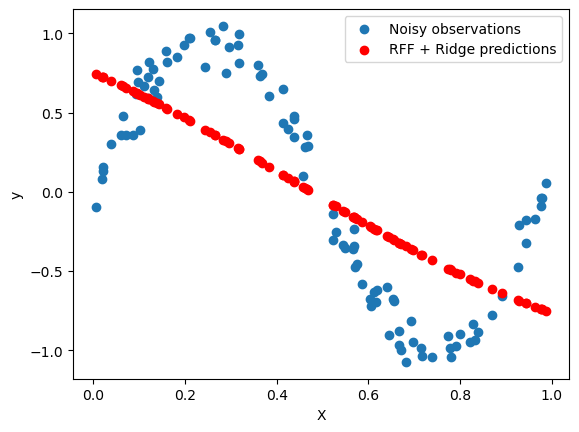

In [19]:
import numpy as np
import matplotlib.pyplot as plt

class RandomFourierFeatures:
    def __init__(self, D, sigma):
        self.D = D  # Number of random features
        self.sigma = sigma  # Kernel parameter (bandwidth for Gaussian kernel)
        self.w = None
        self.b = None

    def fit(self, X):
        d = X.shape[1]
        self.w = np.random.normal(0, 1 / self.sigma, (self.D, d))
        self.b = np.random.uniform(0, 2 * np.pi, self.D)

    def transform(self, X):
        projection = np.dot(X, self.w.T) + self.b
        return np.sqrt(2 / self.D) * np.cos(projection)

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

# Generate synthetic data
np.random.seed(0)
X = np.random.rand(100, 1)  # 100 samples, 1 feature

# Instantiate and fit the Random Fourier Features transformer
rff = RandomFourierFeatures(D=1000, sigma=1.0)
Z = rff.fit_transform(X)

# Display the transformed features
print("Transformed features shape:", Z.shape)

# Fit a linear model on the transformed features
from sklearn.linear_model import Ridge

y = np.sin(2 * np.pi * X).ravel() + 0.1 * np.random.randn(100)

ridge = Ridge(alpha=1.0)
ridge.fit(Z, y)

# Predict using the linear model
y_pred = ridge.predict(Z)

# Plot the results
plt.scatter(X, y, label='Noisy observations')
plt.scatter(X, y_pred, label='RFF + Ridge predictions', color='red')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()


Transformed features shape: (100, 1000)


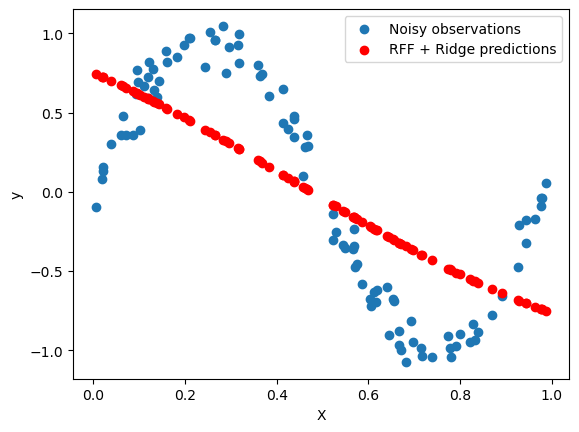

In [20]:
import numpy as np
import matplotlib.pyplot as plt

class RandomFourierFeatures:
    def __init__(self, D, sigma):
        self.D = D  # Number of random features
        self.sigma = sigma  # Kernel parameter (bandwidth for Gaussian kernel)
        self.w = None
        self.b = None

    def fit(self, X):
        d = X.shape[1]
        self.w = np.random.normal(0, 1 / self.sigma, (self.D, d))
        self.b = np.random.uniform(0, 2 * np.pi, self.D)

    def transform(self, X):
        projection = np.dot(X, self.w.T) + self.b
        return np.sqrt(2 / self.D) * np.cos(projection)

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

# Generate synthetic data
np.random.seed(0)
X = np.random.rand(100, 1)  # 100 samples, 1 feature

# Instantiate and fit the Random Fourier Features transformer
rff = RandomFourierFeatures(D=1000, sigma=1.0)
Z = rff.fit_transform(X)

# Display the transformed features
print("Transformed features shape:", Z.shape)

# Fit a linear model on the transformed features
from sklearn.linear_model import Ridge

y = np.sin(2 * np.pi * X).ravel() + 0.1 * np.random.randn(100)

ridge = Ridge(alpha=1.0)
ridge.fit(Z, y)

# Predict using the linear model
y_pred = ridge.predict(Z)

# Plot the results
plt.scatter(X, y, label='Noisy observations')
plt.scatter(X, y_pred, label='RFF + Ridge predictions', color='red')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()


In [21]:
x = np.arange(-10,10+0.01,0.01)

SIGMA2 = 1
LAMBDA2 = 1
def gaussian(tau):
    return SIGMA2 * np.exp(- tau**2 / LAMBDA2 )


gauss_x = gaussian(x)



c:\Users\aejog\anaconda3\Lib\site-packages\scipy\signal\_spectral_py.py:2017: UserWarning: nperseg = 1024 is greater than input length  = 1000, using nperseg = 1000
  warnings.warn('nperseg = {0:d} is greater than input length '


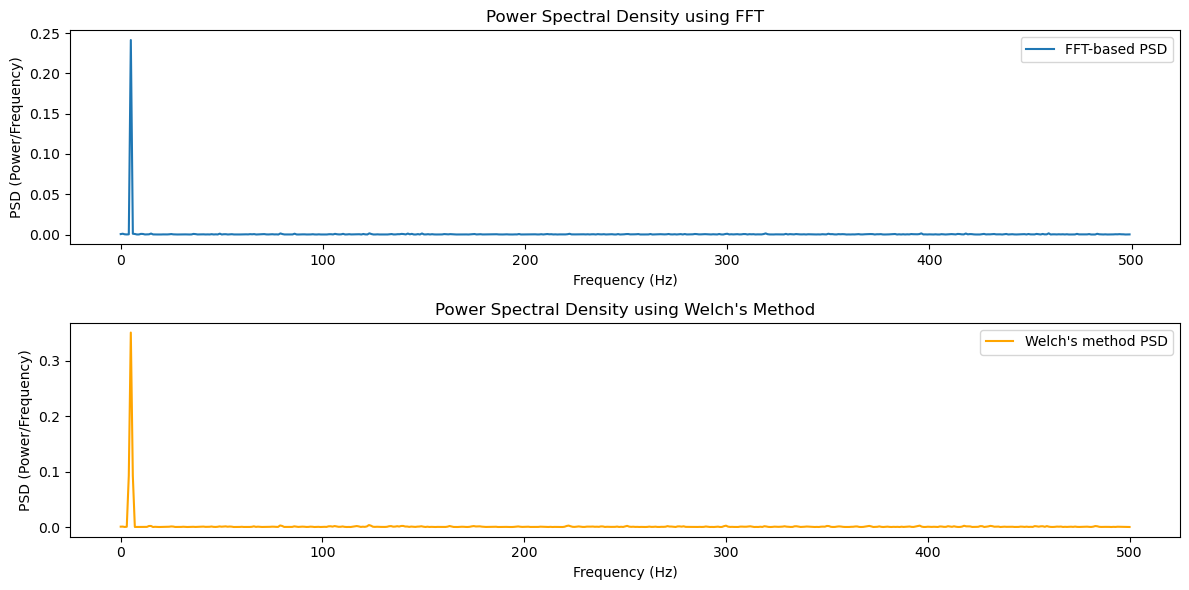

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

# Generate a sample signal: a sine wave with added noise
np.random.seed(0)
fs = 1000  # Sampling frequency
t = np.arange(0, 1, 1/fs)  # Time vector
f = 5  # Signal frequency
signal = np.sin(2 * np.pi * f * t) + 0.5 * np.random.randn(len(t))

# Method 1: Using FFT
def compute_psd_fft(signal, fs):
    N = len(signal)
    fft_values = np.fft.fft(signal)
    fft_freqs = np.fft.fftfreq(N, 1/fs)
    psd = np.abs(fft_values) ** 2 / (fs * N)
    return fft_freqs[:N//2], psd[:N//2]  # Return only the positive frequencies

# Method 2: Using Welch's method
def compute_psd_welch(signal, fs):
    freqs, psd = welch(signal, fs, nperseg=1024)
    return freqs, psd

# Compute PSD using FFT
fft_freqs, psd_fft = compute_psd_fft(signal, fs)

# Compute PSD using Welch's method
welch_freqs, psd_welch = compute_psd_welch(signal, fs)

# Plot the PSD
plt.figure(figsize=(12, 6))

# Plot PSD from FFT
plt.subplot(2, 1, 1)
plt.plot(fft_freqs, psd_fft, label='FFT-based PSD')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (Power/Frequency)')
plt.title('Power Spectral Density using FFT')
plt.legend()

# Plot PSD from Welch's method
plt.subplot(2, 1, 2)
plt.plot(welch_freqs, psd_welch, label="Welch's method PSD", color='orange')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (Power/Frequency)')
plt.title("Power Spectral Density using Welch's Method")
plt.legend()

plt.tight_layout()
plt.show()


(2000, 50)


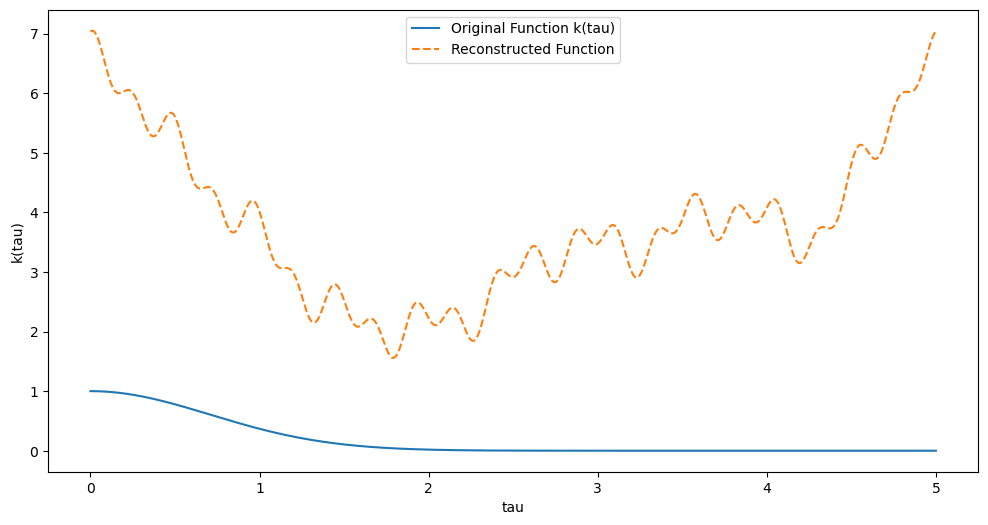

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftfreq

# Define the target function k(tau)
def k(tau):
    return np.exp(-tau**2) #* np.cos(2 * np.pi * 5 * tau)

# Number of sample points
N = 2000
# Sample spacing
T = 5.0 / N
# Generate the tau values
tau = np.linspace(0.0, N*T, N)

# Compute the target function values
k_values = k(tau)
# k_values = X_data[0]
# Compute the Fourier coefficients S(w) using FFT
S_w = fft(k_values)

# Frequencies corresponding to the coefficients
frequencies = fftfreq(N, T)
fft_freqs, psd_fft  = compute_psd_fft(k_values,1/T)
Z = psd_fft.sum()
M = 50
w = np.random.choice(fft_freqs,M,p = psd_fft / Z)
b =  np.random.uniform(0,2*np.pi,M)
def create_phi(w):
    w = 2*np.pi*w[None,:]
    def phi(t):
        t = t[:,None]
        
        return np.sqrt(Z/2*M) * np.cos(w*t) * np.sin(w*t)
    
    return phi

def create_phi(w):
    w = 2*np.pi*w[None,:]
    def phi(t):
        t = t[:,None]
        
        return np.sqrt(Z/M) * np.cos(w*t + b)
    
    return phi

phi = create_phi(w)

phi_tau = phi(tau)

print(phi_tau.shape)
reconstructed_k =  phi_tau @ (np.sqrt(Z/2*M) * np.cos( b))
# # Reconstruct the function using the sum of cosines
# reconstructed_k = np.zeros(N)
# for i in range(N):
#     w = frequencies[i]
#     amplitude = 2.0/N * np.abs(S_w[i])
#     phase = np.angle(S_w[i])
#     reconstructed_k += amplitude * np.cos(2 * np.pi * w * tau + phase)

# Plot the original and reconstructed functions
plt.figure(figsize=(12, 6))
plt.plot(tau, k_values, label='Original Function k(tau)')
plt.plot(tau, reconstructed_k, label='Reconstructed Function', linestyle='--')
plt.xlabel('tau')
plt.ylabel('k(tau)')
plt.legend()
plt.show()